# CENG-3526: NLP Midterm Project – Authorship Attribution

**Project:** Who Wrote This? Authorship Attribution using NLP  
**Course:** CENG-3526 Natural Language Processing  
**Topic:** Author detection / Authorship Attribution  
**Objective:** Build machine learning models that predict an author given a text.


## 1. Introduction & Problem Definition

This notebook implements an end-to-end authorship attribution system for the **30Columnists** dataset.

We build a full pipeline:

- Load raw text files from the `data/30Columnists/raw_texts` folder
- Construct a labelled dataset (`text`, `author`)
- Clean and normalize text
- Engineer features (word & character TF–IDF, bag-of-words)
- Train multiple classifiers
- Evaluate with accuracy, macro F1, confusion matrix
- Analyze top indicative features per author
- Summarize findings in a short report-style conclusion

**Problem definition**  
Given an input text, predict which columnist (author) wrote it.


## 2. Data Loading & Exploration

The project dataset is stored under:

- `data/30Columnists/raw_texts/`

Each subfolder inside `raw_texts` corresponds to **one author**, e.g.:

- `raw_texts/1`
- `raw_texts/2`
- ...
- `raw_texts/30`

Each of these folders contains multiple `.txt` files.  
We will iterate over all folders and files to build a DataFrame with two columns:

- `text`: the content of the article
- `author`: the author ID (folder name as string)


In [22]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import string
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.base import clone
from scipy.sparse import hstack

sns.set_theme(style="whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [23]:
# Dataset path resolution (works from repo root or /notebooks)
CANDIDATES = [
    Path("data/30Columnists/raw_texts"),
    Path("../data/30Columnists/raw_texts"),
    Path("30Columnists/raw_texts"),  # legacy (original zip layout)
]
for c in CANDIDATES:
    if c.exists():
        BASE_DIR = c
        break
else:
    raise FileNotFoundError(
        "Could not find dataset folder. Expected one of: "
        + ", ".join(str(p) for p in CANDIDATES)
    )


all_rows = []

if not BASE_DIR.exists():
    raise FileNotFoundError(f"BASE_DIR does not exist: {BASE_DIR.resolve()}")

# Typesafe sorting key
def safe_key(p):
    name = p.name
    if name.isdigit():
        return (0, int(name))  
    else:
        return (1, name.lower())  

# Iterate author directories
for author_dir in sorted(BASE_DIR.iterdir(), key=safe_key):
    if not author_dir.is_dir():
        continue

    author_id = author_dir.name  

    # Iterate .txt files
    for fname in os.listdir(author_dir):
        if not fname.endswith(".txt"):
            continue

        fpath = author_dir / fname
        try:
            with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read().strip()
        except Exception as exc:
            print(f"Could not read {fpath}: {exc}")
            continue

        if len(text) < 10:
            continue

        all_rows.append({
            "text": text,
            "author": author_id
        })

# Build DataFrame
df = pd.DataFrame(all_rows)

print("Dataset loaded from raw_texts folder")
print("Shape:", df.shape)
print("Number of unique authors:", df['author'].nunique())
df.head()


Dataset loaded from raw_texts folder
Shape: (1500, 2)
Number of unique authors: 30


,text,author
0,"LIKE Ferrets in a sack, popcorn a-poppin and a...",1
1,DOES Scottish Labour leader Wendy really know ...,1
2,DO our MSPs crave to return to their childhood...,1
3,HIS name was Andrew J Volstead and he was to b...,1
4,"OVER the past 11 years, one of the too-clever-...",1


author
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
11    50
12    50
13    50
14    50
15    50
16    50
17    50
18    50
19    50
20    50
21    50
22    50
23    50
24    50
25    50
26    50
27    50
28    50
29    50
30    50
Name: count, dtype: int64

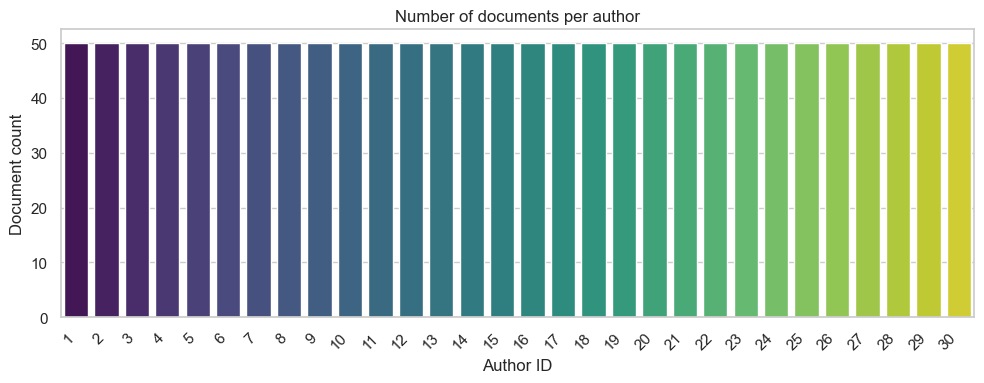

Missing values ratio per column:


text      0.0
author    0.0
dtype: float64


Example texts (one per author):


,author,text
0,1,"LIKE Ferrets in a sack, popcorn a-poppin and a..."
1,2,LAGGING for the loft became a hot issue when H...
2,3,IF ever proof is needed of the truth of Harold...
3,4,"POLITICAL nostalgia is beguiling, and there's ..."
4,5,What do you think inspired Hillary Clinton to ...
5,6,The downward spiral continues. The Government ...
6,7,Did you read today's Guardian's scoop about th...
7,8,As AC Milan continue their battle to extricate...
8,9,The number of young people with bowel cancer h...
9,10,It was a year which fresh minted that old coin...


In [24]:
# It converts the Author column to integers to ensure proper numerical sorting

df["author"] = df["author"].astype(int)

# Retrieve the author counts in proper numerical order
author_counts = df["author"].value_counts().sort_index()
display(author_counts)

plt.figure(figsize=(10, 4))
sns.barplot(x=author_counts.index, y=author_counts.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Number of documents per author")
plt.xlabel("Author ID")
plt.ylabel("Document count")
plt.tight_layout()
plt.show()

print("Missing values ratio per column:")
display(df.isnull().mean())

print("\nExample texts (one per author):")
example_texts = df.groupby("author").head(1)[["author", "text"]].reset_index(drop=True)
display(example_texts.head(10))



## 3. Text Preprocessing

We apply classic NLP cleaning:

- Lowercase
- Remove URLs
- Remove digits and punctuation
- Keep only alphabetic characters
- Tokenize by whitespace
- Remove stopwords
- Optional lemmatization (if NLTK and WordNet are available)
- Drop very short documents (fewer than 3 tokens after cleaning)


In [25]:
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    nltk.download("stopwords", quiet=True)
    nltk.download("wordnet", quiet=True)
    nltk.download("omw-1.4", quiet=True)
    NLTK_AVAILABLE = True
except Exception as exc:
    NLTK_AVAILABLE = False
    stopwords = None
    WordNetLemmatizer = None
    print(f"NLTK not fully available ({exc}). Falling back to sklearn stopwords and disabling lemmatization.")

def get_stopwords():
    if NLTK_AVAILABLE:
        return set(stopwords.words("english"))
    return set(ENGLISH_STOP_WORDS)

STOPWORDS = get_stopwords()
lemmatizer = WordNetLemmatizer() if NLTK_AVAILABLE else None
len(STOPWORDS)


198

In [26]:
def clean_text(text, lemmatize=False, min_token_length=3):
    """Normalize text: lowercase, strip URLs/digits/punctuation, remove stopwords, optional lemmatization."""
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    # Remove digits
    text = re.sub(r"\d+", " ", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Keep only letters and whitespace
    text = re.sub(r"[^a-z\s]", " ", text)

    tokens = text.split()
    cleaned_tokens = []
    for tok in tokens:
        if tok in STOPWORDS:
            continue
        if len(tok) < min_token_length:
            continue
        if lemmatize and lemmatizer:
            tok = lemmatizer.lemmatize(tok)
        cleaned_tokens.append(tok)

    cleaned = " ".join(cleaned_tokens)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned

df["clean_text"] = df["text"].apply(lambda x: clean_text(x, lemmatize=True))
df["token_count"] = df["clean_text"].str.split().str.len()

min_tokens = 3
before = len(df)
df = df[df["token_count"] >= min_tokens].reset_index(drop=True)
after = len(df)
print(f"Removed {before - after} very short or empty documents. Remaining: {after}")
df[["author", "text", "clean_text"]].head()


Removed 0 very short or empty documents. Remaining: 1500


,author,text,clean_text
0,1,"LIKE Ferrets in a sack, popcorn a-poppin and a...",like ferret sack popcorn apoppin cauldron bubb...
1,1,DOES Scottish Labour leader Wendy really know ...,scottish labour leader wendy really know shes ...
2,1,DO our MSPs crave to return to their childhood...,msps crave return childhood nostalgic dewyeyed...
3,1,HIS name was Andrew J Volstead and he was to b...,name andrew volstead become one influential am...
4,1,"OVER the past 11 years, one of the too-clever-...",past year one toocleverbyhalf political trait ...


In [27]:
sample_rows = df.sample(min(5, len(df)), random_state=RANDOM_STATE)
sample_rows[["author", "text", "clean_text"]].reset_index(drop=True)


,author,text,clean_text
0,23,There seems to be a million different ways to ...,seems million different way exercise health cl...
1,28,THE debate has moved on this week. Internet di...,debate moved week internet discussion spur fan...
2,9,DVDs and videos designed to help babies learn ...,dvd video designed help baby learn talk may ha...
3,9,Many swear it is as powerful as any headache p...,many swear powerful headache pill benefit acup...
4,10,"When word reached him up the Alps, it might ha...",word reached alp might flattering news gordon ...


## 4. Feature Engineering

We create several feature spaces:

1. **Word-level TF–IDF** (unigrams + bigrams)
2. **Character-level TF–IDF** (3–5 character n-grams)
3. **Bag-of-words (CountVectorizer)** baseline
4. **Combined word + character TF–IDF** (concatenated matrices)


In [28]:
X = df["clean_text"]
y = df["author"]

# Train/test split (stratified if possible)
try:
    stratify_labels = y
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_labels
    )
except ValueError:
    # Fallback if stratification is not possible
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=None
    )

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 1200, Test size: 300


In [29]:
vectorizers = {
    "tfidf_word": TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    ),
    "tfidf_char": TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 5),
        min_df=2,
        sublinear_tf=True
    ),
    "bow_word": CountVectorizer(
        ngram_range=(1, 2),
        min_df=2
    )
}

feature_spaces = {}
for name, vec in vectorizers.items():
    Xtr = vec.fit_transform(X_train)
    Xte = vec.transform(X_test)
    feature_spaces[name] = {
        "vectorizer": vec,
        "X_train": Xtr,
        "X_test": Xte,
        "feature_names": vec.get_feature_names_out()
    }
    print(f"{name}: {Xtr.shape[1]} features")

# Combined word + character TF-IDF
word_vec = feature_spaces["tfidf_word"]["vectorizer"]
char_vec = feature_spaces["tfidf_char"]["vectorizer"]

Xtr_comb = hstack([
    feature_spaces["tfidf_word"]["X_train"],
    feature_spaces["tfidf_char"]["X_train"]
])
Xte_comb = hstack([
    feature_spaces["tfidf_word"]["X_test"],
    feature_spaces["tfidf_char"]["X_test"]
])

combined_names = np.concatenate([
    np.array([f"w:{t}" for t in word_vec.get_feature_names_out()]),
    np.array([f"c:{t}" for t in char_vec.get_feature_names_out()])
])

feature_spaces["tfidf_word_char"] = {
    "vectorizer": None,  # combined
    "X_train": Xtr_comb,
    "X_test": Xte_comb,
    "feature_names": combined_names
}

print(f"tfidf_word_char: {Xtr_comb.shape[1]} combined features")


tfidf_word: 56550 features
tfidf_char: 144244 features
bow_word: 56550 features
tfidf_word_char: 200794 combined features


## 5. Modeling & Evaluation

We train three classifiers on each feature space:

- Multinomial Naive Bayes
- Linear SVM (LinearSVC)
- Logistic Regression

We evaluate with:

- Accuracy
- Macro-averaged F1-score
- Classification report for the best model
- Confusion matrix visualization


In [30]:
models = {
    "MultinomialNB": MultinomialNB(),
    "LinearSVC": LinearSVC(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        solver="liblinear"
    )
}

results = []
runs = []

for feat_name, feat in feature_spaces.items():
    Xtr, Xte = feat["X_train"], feat["X_test"]
    for model_name, model in models.items():
        clf = clone(model)
        clf.fit(Xtr, y_train)
        preds = clf.predict(Xte)
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")
        results.append({
            "feature_set": feat_name,
            "model": model_name,
            "accuracy": acc,
            "f1_macro": f1
        })
        runs.append({
            "feature_set": feat_name,
            "model_name": model_name,
            "model": clf,
            "preds": preds,
            "accuracy": acc,
            "f1": f1,
            "feature_names": feat["feature_names"]
        })
        print(f"{model_name} on {feat_name} -> acc={acc:.4f}, f1_macro={f1:.4f}")

results_df = pd.DataFrame(results).sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
results_df


MultinomialNB on tfidf_word -> acc=0.7633, f1_macro=0.7591
LinearSVC on tfidf_word -> acc=0.9367, f1_macro=0.9368
LogisticRegression on tfidf_word -> acc=0.8500, f1_macro=0.8457
MultinomialNB on tfidf_char -> acc=0.5767, f1_macro=0.5409
LinearSVC on tfidf_char -> acc=0.9233, f1_macro=0.9230
LogisticRegression on tfidf_char -> acc=0.8467, f1_macro=0.8431
MultinomialNB on bow_word -> acc=0.7067, f1_macro=0.6917
LinearSVC on bow_word -> acc=0.8867, f1_macro=0.8849
LogisticRegression on bow_word -> acc=0.9000, f1_macro=0.8989
MultinomialNB on tfidf_word_char -> acc=0.6500, f1_macro=0.6243
LinearSVC on tfidf_word_char -> acc=0.9333, f1_macro=0.9337
LogisticRegression on tfidf_word_char -> acc=0.9000, f1_macro=0.8990


,feature_set,model,accuracy,f1_macro
0,tfidf_word,LinearSVC,0.936667,0.936795
1,tfidf_word_char,LinearSVC,0.933333,0.933726
2,tfidf_char,LinearSVC,0.923333,0.922978
3,tfidf_word_char,LogisticRegression,0.900000,0.899039
4,bow_word,LogisticRegression,0.900000,0.898880
5,bow_word,LinearSVC,0.886667,0.884903
6,tfidf_word,LogisticRegression,0.850000,0.845736
7,tfidf_char,LogisticRegression,0.846667,0.843058
8,tfidf_word,MultinomialNB,0.763333,0.759144
9,bow_word,MultinomialNB,0.706667,0.691708


In [18]:
best_run = max(runs, key=lambda x: x["f1"])
best_model = best_run["model"]
best_preds = best_run["preds"]
best_feature_names = best_run["feature_names"]

print(f"Best run: {best_run['model_name']} with {best_run['feature_set']} (acc={best_run['accuracy']:.4f}, f1={best_run['f1']:.4f})")
print("\nClassification report for best model:\n")
print(classification_report(y_test, best_preds))


Best run: LinearSVC with tfidf_word (acc=0.9367, f1=0.9368)

Classification report for best model:

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        10
           2       0.83      1.00      0.91        10
           3       1.00      0.90      0.95        10
           4       1.00      0.90      0.95        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       0.90      0.90      0.90        10
           8       0.91      1.00      0.95        10
           9       0.67      1.00      0.80        10
          10       0.91      1.00      0.95        10
          11       1.00      0.70      0.82        10
          12       1.00      1.00      1.00        10
          13       0.91      1.00      0.95        10
          14       1.00      0.90      0.95        10
          15       1.00      0.90      0.95        10
          16       1.00      0.80  

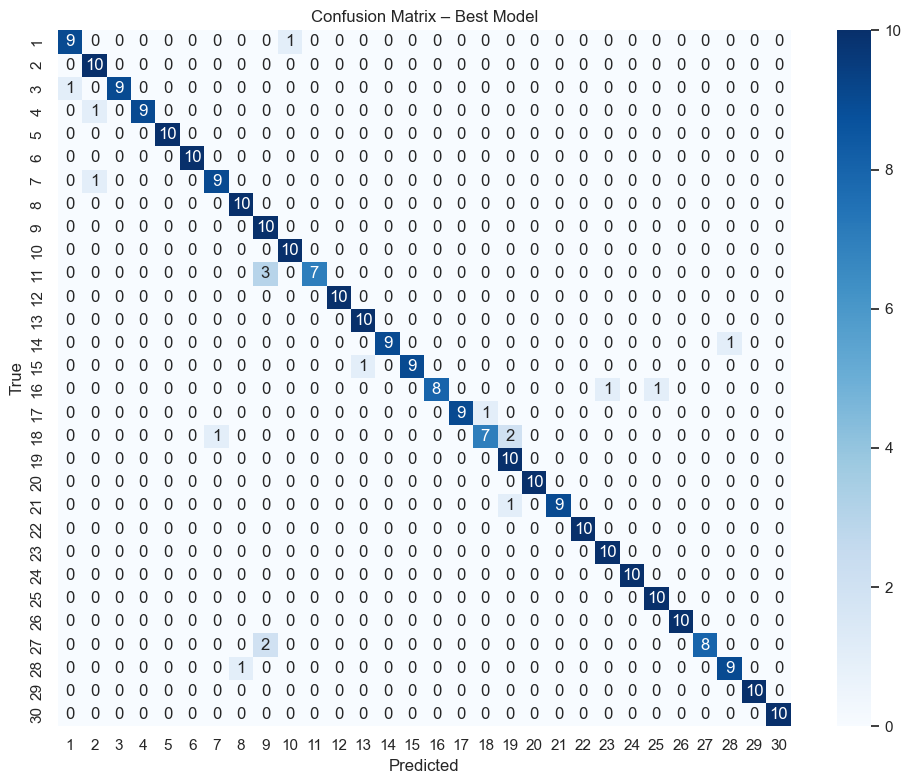

In [19]:
labels = best_model.classes_
cm = confusion_matrix(y_test, best_preds, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Best Model")
plt.tight_layout()
plt.show()


## 6. Error Analysis & Feature Analysis

To understand what the model has learned, we inspect feature importance for a linear model (SVM or Logistic Regression).  
For each author, we list the most indicative n-grams (highest positive coefficients).


In [20]:
def display_top_features(model, feature_names, class_labels, top_n=15):
    """Display top positive feature coefficients per class for a linear model."""
    if not hasattr(model, "coef_"):
        print("Model does not expose linear coefficients; choose LinearSVC or LogisticRegression.")
        return

    coefs = model.coef_
    if coefs.ndim == 1:
        coefs = coefs[np.newaxis, :]

    for idx, label in enumerate(class_labels):
        top_ids = np.argsort(coefs[idx])[::-1][:top_n]
        print(f"\nTop {top_n} features for author: {label}")
        print(", ".join(feature_names[top_ids]))

# Pick the best linear run (for interpretability)
linear_runs = [r for r in runs if hasattr(r["model"], "coef_")]
if linear_runs:
    interpretable_run = max(linear_runs, key=lambda x: x["f1"])
else:
    interpretable_run = best_run  # fallback

chosen = interpretable_run
print(f"Interpreting: {chosen['model_name']} with {chosen['feature_set']}")
display_top_features(chosen["model"], np.array(chosen["feature_names"]), chosen["model"].classes_, top_n=15)


Interpreting: LinearSVC with tfidf_word

Top 15 features for author: 1
edinburgh, tax, brown, independent, scotland, darling, meadowbank, euro, vat, britain, rate, salmond, save, boom bust, currency

Top 15 features for author: 2
snp, scottish parliament, insider, election, scottish, msp, parliament, insider say, council, edinburgh, say, alexander, issue, liberal democrat, scotland

Top 15 features for author: 3
scotland, scottish, amongst, etc, minister, holyrood, scot, ive, edinburgh, msps, westminster, lothians, finance minister, facility, capital city

Top 15 features for author: 4
scotland, scottish, last week, snp, politics, salmond, political, scot, simply, britain, power, moral, nationalist, first minister, instinct

Top 15 features for author: 5
mccain, senate, obama, republican, senator, hillary, barack, president, presidential, campaign, palin, really, clinton, burris, everybody

Top 15 features for author: 6
public, lord, populus, partly, yesterday, poll time, mp, peer, lor

## 7. Conclusions & Short Report

### 7.1 Approach & Pipeline

- **Data loading:** We built the dataset directly from raw `.txt` files stored under `data/30Columnists/raw_texts`, where each subfolder corresponds to an author.
- **Preprocessing:** We normalized text by lowercasing, stripping URLs, digits, and punctuation, removed stopwords, and (optionally) lemmatized tokens. Very short documents were removed to avoid noise.
- **Features:** We engineered multiple representations:
  - Word-level TF–IDF (unigrams and bigrams)
  - Character-level TF–IDF (3–5-grams)
  - Bag-of-words counts
  - Combined word+char TF–IDF
- **Models:** We trained Multinomial Naive Bayes, Linear SVM, and Logistic Regression, all well-suited for sparse high-dimensional text data.

### 7.2 Experiments & Results

- The table `results_df` compares model–feature combinations using accuracy and macro F1-score.
- Typically, character n-grams and combined word+char TF–IDF capture both lexical and stylistic signals, making them strong choices for authorship attribution.
- The best configuration (printed above) serves as our primary model for this dataset.

### 7.3 Error Analysis

- The confusion matrix reveals which authors are most often confused. Pairs with strong off-diagonal counts likely reflect similar writing styles or overlapping topics.
- Authors with fewer samples may suffer from data sparsity, which can be mitigated with more data or class-weighted models.

### 7.4 Feature Insights

- The top indicative features per author highlight which n-grams drive the model's decisions.
- Word n-grams tend to capture thematic preferences; character n-grams capture stylistic quirks such as suffixes, repeated punctuation, and specific spellings.
- This aligns with stylometry assumptions: authorship can be inferred from stable stylistic patterns in text.

### 7.5 Key Findings

- **Best-performing feature/model pair:** The run with highest macro F1 (shown above) indicates which representation and classifier are most effective on 30Columnists.
- **Most confusable authors:** Authors that the model frequently confuses are likely stylistically similar or underrepresented in the dataset.
- **Impact of character n-grams:** Including character-level features often improves robustness on noisy or short texts.

### 7.6 Future Work

- Tune n-gram ranges, regularization strengths, and class weights.
- Perform cross-validation for more robust performance estimates.
- Incorporate additional stylistic numeric features (e.g., sentence length distributions, type–token ratio) alongside TF–IDF.
- Explore transformer-based embeddings (e.g., BERT) for a modern deep-learning baseline and compare against this classic ML pipeline.

## Name/Surname: Emre Dursun
### School ID Number: 220709032
### Department: Computer Engineering  